<a href="https://colab.research.google.com/github/AdityaGhatty/Datascience/blob/main/Adit_GhatU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Your file on your github needs to be a a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U6proj.

Ex1.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU8proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU8proj.ipynb"

# Unit 8 Project: Writing a BARTical

**Task**:

Two parts:

1. Propose a data set that's compatible with a pymc_bart model. I must approve your submission before you move on to part 2.

2. Create, analyze, and present BART model, using pymc_bart within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is)
  - You must argue why your variable selection is justified. You may use either a theoretical or numerical argument. Additionally, you must comment on any potential interactions between your predictor variables.



# UNIT 8 - PREDICTING CREDIT CARD DEFAULTS

Predicting the types of people most likely to pay you back is something that is extremely important in finance, and something we all do. While I try to be judicious in who I let "cashapp me later", banks and loan people rely on real data and statistics to minimize the risk of lending to someone who will not, in fact, cashapp them later. I'm using data from Taiwan that includes some demographic stuff like who's married, their education level, etc, as well as repayment and billing history for 30k clients. The goal is to see what features are best for predicting credit card payment defaults for the next month.

##Data/Imports

In [1]:
!pip install preliz
!pip install pymc-bart
import preliz as pz
import pymc as pm
import numpy as np
import pymc_bart as pmb
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi
import bambi as bmb

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-yplq8t3z
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-yplq8t3z
  Resolved https://github.com/pydata/xarray.git to commit aa9e2bd407a47cef1ec7f1d9498e4a1118bc440e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.3.2.dev11+gaa9e2bd4-py3-none-any.whl size=1279862 sha256=33acb4d8dfbd2e11f1d305d23182a27034ed3b9006d629bfa05ab46fb529e3c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-icuwkct_/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.5 MB/s eta 0:00:00


In [2]:
c = pd.read_csv('https://raw.githubusercontent.com/AdityaGhatty/Datascience/refs/heads/main/UCI_Credit_Card.csv')
c


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


Variable explanations -

Limit_Bal is the amount of credit given to the client, showing how much a bank already trusts them. Better credit score and history, more money they're potentially allowed. This is probably a solid indicator on its own.


---


education (starts from grad school (1) and goes down to high school(4)



---


Pay_(0) - Pay_0 is the most recent month, september, and -1 shows paid on time, and every positive integer is the number of months the payment has been delayed (higher number, more delay)


---


pay_(2-6) - same delay system, but for earlier months (august to april) I think this could be predictive as well but I feel like the most recent month shows where a person currently is financially.



---

Bill_AMT/Pay_AMT(1-6) - monthly bills/amount paid in dollars


---

default.payment.next.month - 1 is default, 0 is no default

## MODEL 1 - "LIMIT_BAL", "PAY_0", "BILL_AMT1", "PAY_AMT1"

Output()

Output()

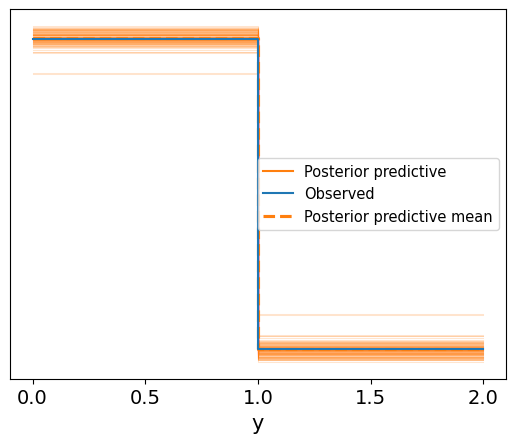

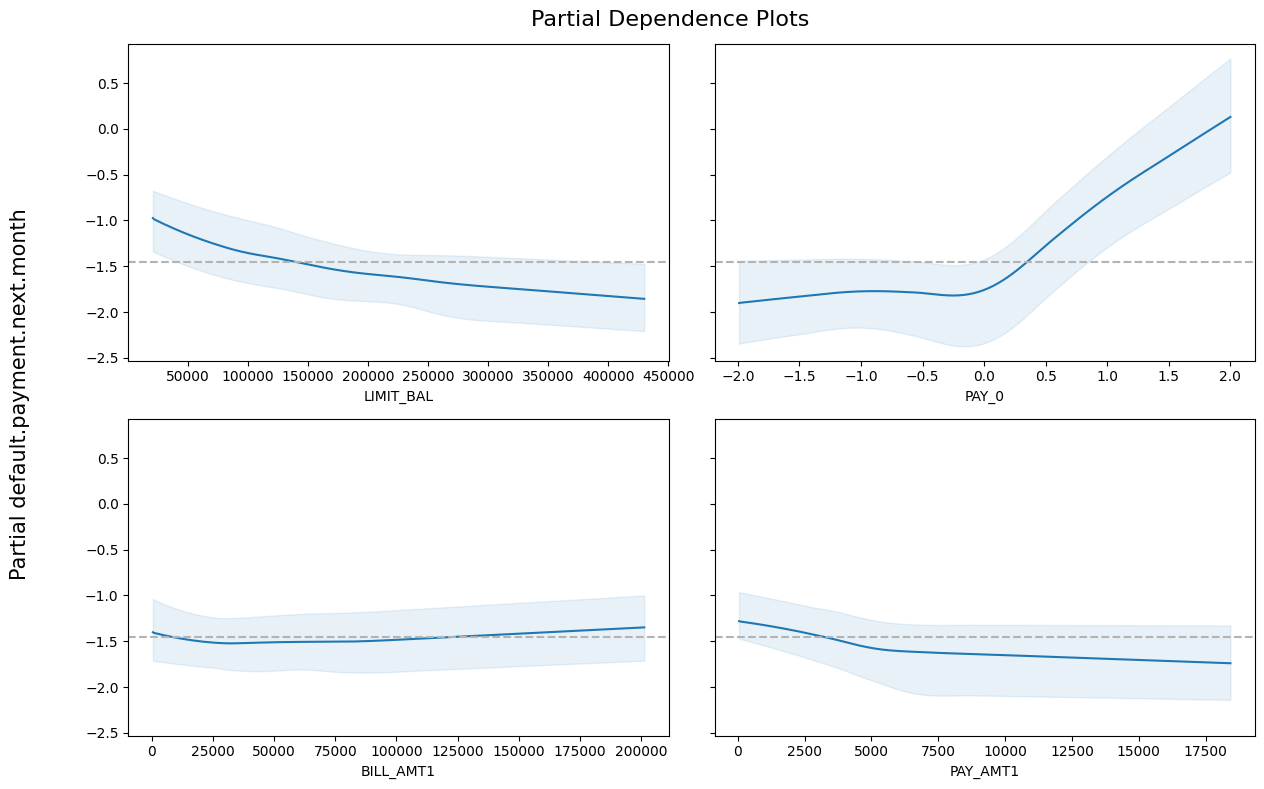

<Axes: ylabel='R²'>

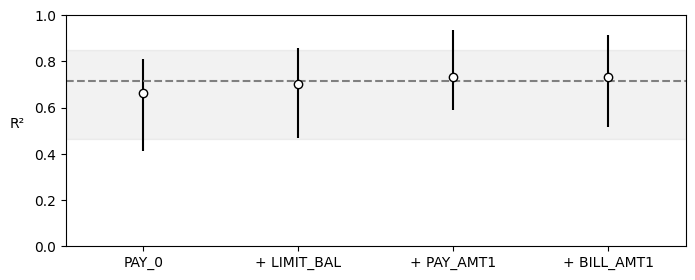

In [3]:
X = c[["LIMIT_BAL", "PAY_0", "BILL_AMT1", "PAY_AMT1"]]
Y = c["default.payment.next.month"]
X = pd.get_dummies(X, drop_first=True)
with pm.Model() as model:
    μ_ = pmb.BART('μ_', X, Y, m=20)
    p = pm.Deterministic('p', pm.math.sigmoid(μ_))
    y = pm.Bernoulli('y', p=p, observed=Y)

    idata = pm.sample(
        draws=200,
        tune=100,
        chains=1,
        cores=1,
        compute_convergence_checks=False,
        progressbar=True
    )
pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

feature_names = ["LIMIT_BAL", "PAY_0", "BILL_AMT1", "PAY_AMT1"]

pmb.plot_pdp(μ_, X, Y, grid=(2, 2), figsize=(12, 8))
plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout()
plt.show()


vi_X = pmb.compute_variable_importance(idata, μ_, X)


pmb.plot_variable_importance(vi_X)

Also note, because I'm testing out multiple different models here, I made some changes to make each model run faster and decrease run times from 40 minutes to like 1 or 2.

This model looks pretty good. I've went with Limit Bal and Pay_0 which I kinda thought might have a good effect, and for the first model I also went with Bill and Pay amounts. The PDP plots show kinda what I thought for the first two variables:

More credit limit, less likelihood of default.

More months of payment delay, more likelihood of default.

For bill amt, it does generally show more bills, more likely to default, and the opposite trend for payment which makes sense.

some outliers. otherwise very cool

## MODEL 2 - "LIMIT_BAL", "PAY_0", "AGE", "EDUCATION", "SEX", "MARRIAGE"

Output()

Output()

/usr/local/lib/python3.11/dist-packages/pymc_bart/utils.py:516: UserWarning: The grid is smaller than the number of available variables to plot.
                Automatically adjusting the grid size.
  warnings.warn(


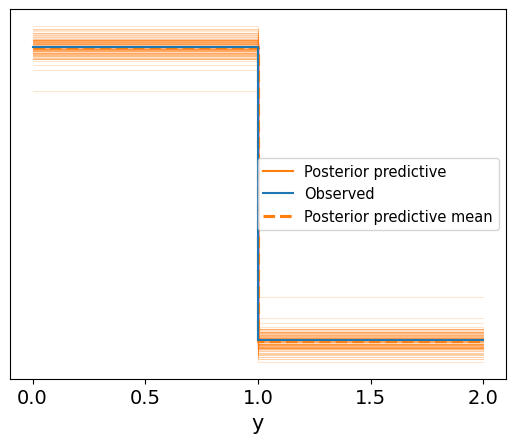

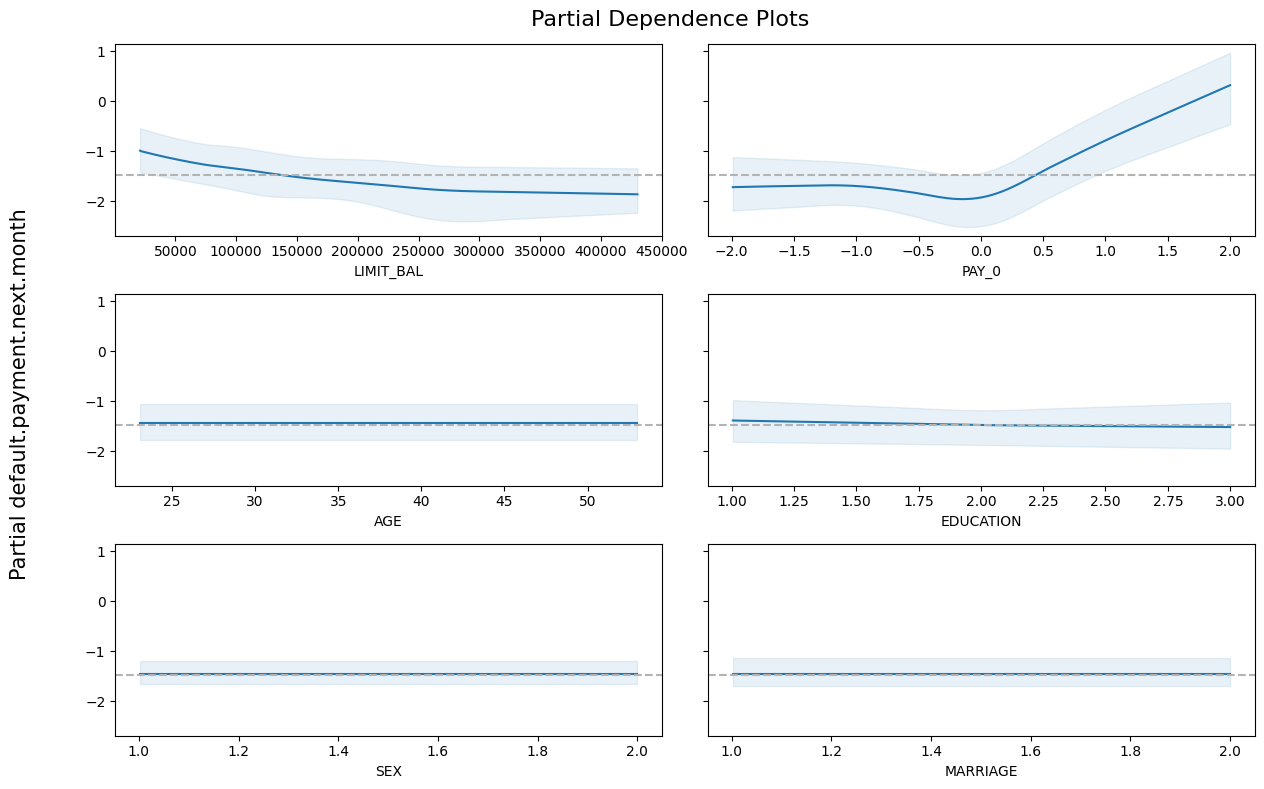

<Axes: ylabel='R²'>

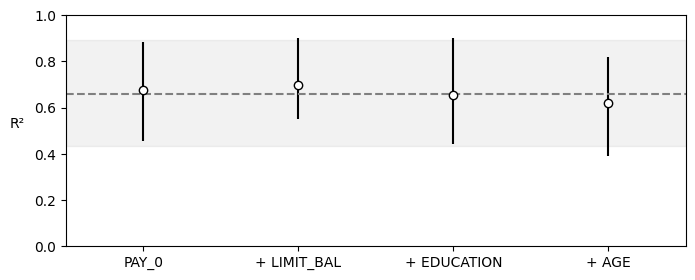

In [12]:
X1 = c[["LIMIT_BAL", "PAY_0", "AGE", "EDUCATION", "SEX", "MARRIAGE"]]
Y1 = c["default.payment.next.month"]
X1 = pd.get_dummies(X, drop_first=True)
with pm.Model() as model:
    μ_ = pmb.BART('μ_', X1, Y1, m=20)
    p = pm.Deterministic('p', pm.math.sigmoid(μ_))
    y = pm.Bernoulli('y', p=p, observed=Y1)

    idata = pm.sample(
        draws=200,
        tune=100,
        chains=1,
        cores=1,
        compute_convergence_checks=False,
        progressbar=True
    )


pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])


X1 = c[["LIMIT_BAL", "PAY_0", "AGE", "EDUCATION", "SEX", "MARRIAGE"]]
pmb.plot_pdp(μ_, X1, Y1, grid=(2, 2), figsize=(12, 8))
plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout()
plt.show()


vi_X1 = pmb.compute_variable_importance(idata, μ_, X1)

pmb.plot_variable_importance(vi_X1)

Looks like the factors don't move the likelihood around?? I'm going to remove them and see if that's true.

Also something I thought of, was that I don't really know as much about cultural factors in Taiwan. In the U.S, I can kinda think of how gender, age, education, etc would impact finances, but not as much in the context of Taiwan.

**Interesting to note, but I also ran this model without marriage and sex. Without these two variables, Education didn't have any noticeable trend. Now that I've added these two, education changed as well with more education meaning less defaultability (but the model doesn't have anymore or less predicting power)... Interesting stuff

## MODEL 3 - REMOVING AGE, EDUCATION TO TEST IMPORTANCE

Output()

Output()

<Axes: xlabel='y'>

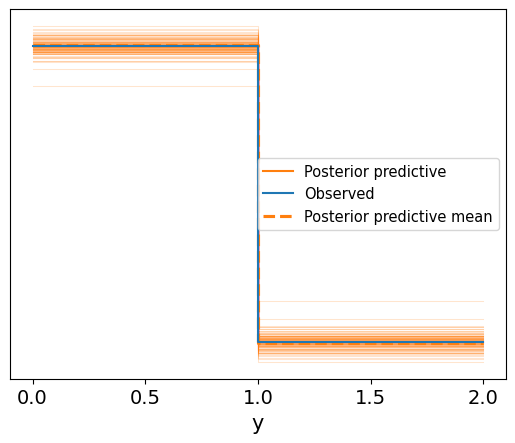

In [6]:
X = c[["LIMIT_BAL", "PAY_0"]]
Y = c["default.payment.next.month"]
X = pd.get_dummies(X, drop_first=True)

X = c[["LIMIT_BAL", "PAY_0"]]
#pmb.plot_pdp(μ_, X, Y, grid=(2, 2), figsize=(12, 8))
#plt.suptitle("Partial Dependence Plots", fontsize=16)
#plt.tight_layout()
#plt.show()

with pm.Model() as model:
    μ_ = pmb.BART('μ_', X, Y, m=20)
    p = pm.Deterministic('p', pm.math.sigmoid(μ_))
    y = pm.Bernoulli('y', p=p, observed=Y)

    idata = pm.sample(
        draws=200,
        tune=100,
        chains=1,
        cores=1,
        compute_convergence_checks=False,
        progressbar=True
    )

pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

Just eyeballing it here, but I think the model was better with the other factors, but not noticeably. I think the financial predictors are better than the social ones

## All Financials

Output()

Output()

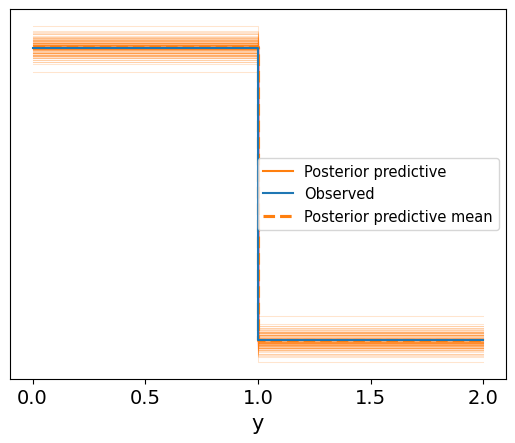

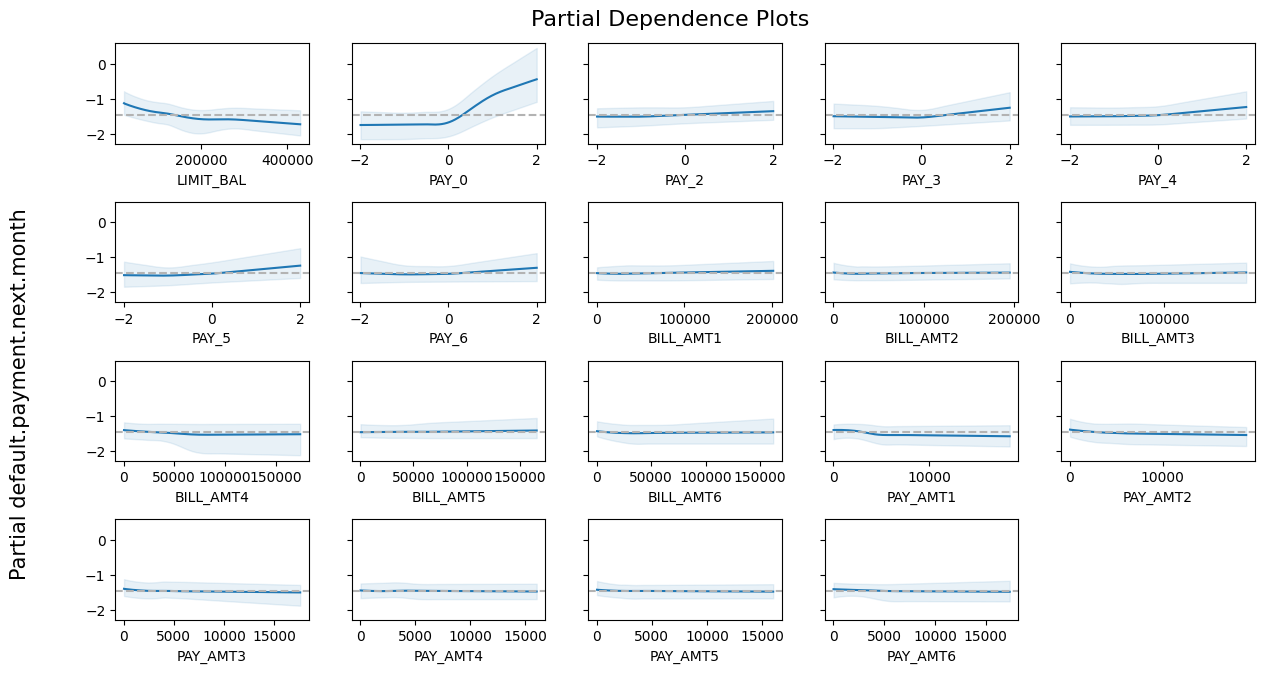

In [15]:
X = c[[
    "LIMIT_BAL",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3",
    "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3",
    "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"
]]
Y = c["default.payment.next.month"]
X = pd.get_dummies(X, drop_first=True)

X = c[[#I dont actually know why I have two X =s for all models. I made one model, copied all code into one cell to run easier, and copied that for every other model.
    "LIMIT_BAL",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3",
    "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3",
    "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"
]]

with pm.Model() as model:
    μ_ = pmb.BART('μ_', X, Y, m=20)
    p = pm.Deterministic('p', pm.math.sigmoid(μ_))
    y = pm.Bernoulli('y', p=p, observed=Y)

    idata = pm.sample(
        draws=200,
        tune=100,
        chains=1,
        cores=1,
        compute_convergence_checks=False,
        progressbar=True
    )

pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])


pmb.plot_pdp(μ_, X, Y, grid=(5, 5), figsize=(12, 8))
plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout()
plt.show()

Best model I've had so far, and coolest PDP's. Looks like all financial variables have an effect, with the same relationships I've noted before. Most importantly, payment delays

I'd worry about overfitting and do something like only use months 0, 5, and 6 for all these variables but I have 30k datapoints and a lot of other models I want to try.

## MODEL 4 - EVERYTHING MODEL

Output()

Output()

<Axes: xlabel='y'>

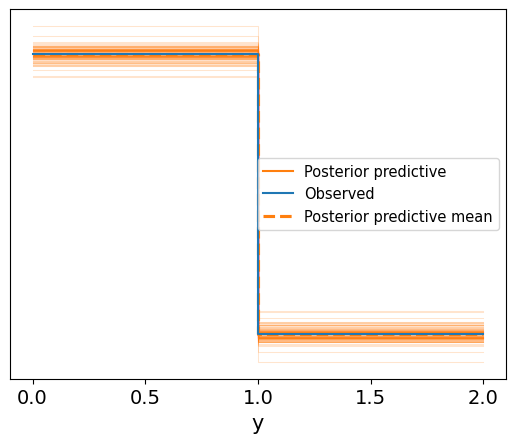

In [8]:
X_all = c.drop(columns=["default.payment.next.month"])

Y = c["default.payment.next.month"]
X_all = pd.get_dummies(X, drop_first=True)



with pm.Model() as model:
    μ_ = pmb.BART('μ_', X_all, Y, m=20)
    p = pm.Deterministic('p', pm.math.sigmoid(μ_))
    y = pm.Bernoulli('y', p=p, observed=Y)

    idata = pm.sample(
        draws=200,
        tune=100,
        chains=1,
        cores=1,
        compute_convergence_checks=False,
        progressbar=True
    )


pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

array([<Axes: xlabel='LIMIT_BAL'>, <Axes: xlabel='SEX'>,
       <Axes: xlabel='EDUCATION'>, <Axes: xlabel='MARRIAGE'>,
       <Axes: xlabel='AGE'>, <Axes: xlabel='PAY_0'>,
       <Axes: xlabel='PAY_2'>, <Axes: xlabel='PAY_3'>,
       <Axes: xlabel='PAY_4'>, <Axes: xlabel='PAY_5'>,
       <Axes: xlabel='PAY_6'>, <Axes: xlabel='BILL_AMT1'>,
       <Axes: xlabel='BILL_AMT2'>, <Axes: xlabel='BILL_AMT3'>,
       <Axes: xlabel='BILL_AMT4'>, <Axes: xlabel='BILL_AMT5'>,
       <Axes: xlabel='BILL_AMT6'>, <Axes: xlabel='PAY_AMT1'>,
       <Axes: xlabel='PAY_AMT2'>, <Axes: xlabel='PAY_AMT3'>,
       <Axes: xlabel='PAY_AMT4'>, <Axes: xlabel='PAY_AMT5'>,
       <Axes: xlabel='PAY_AMT6'>], dtype=object)

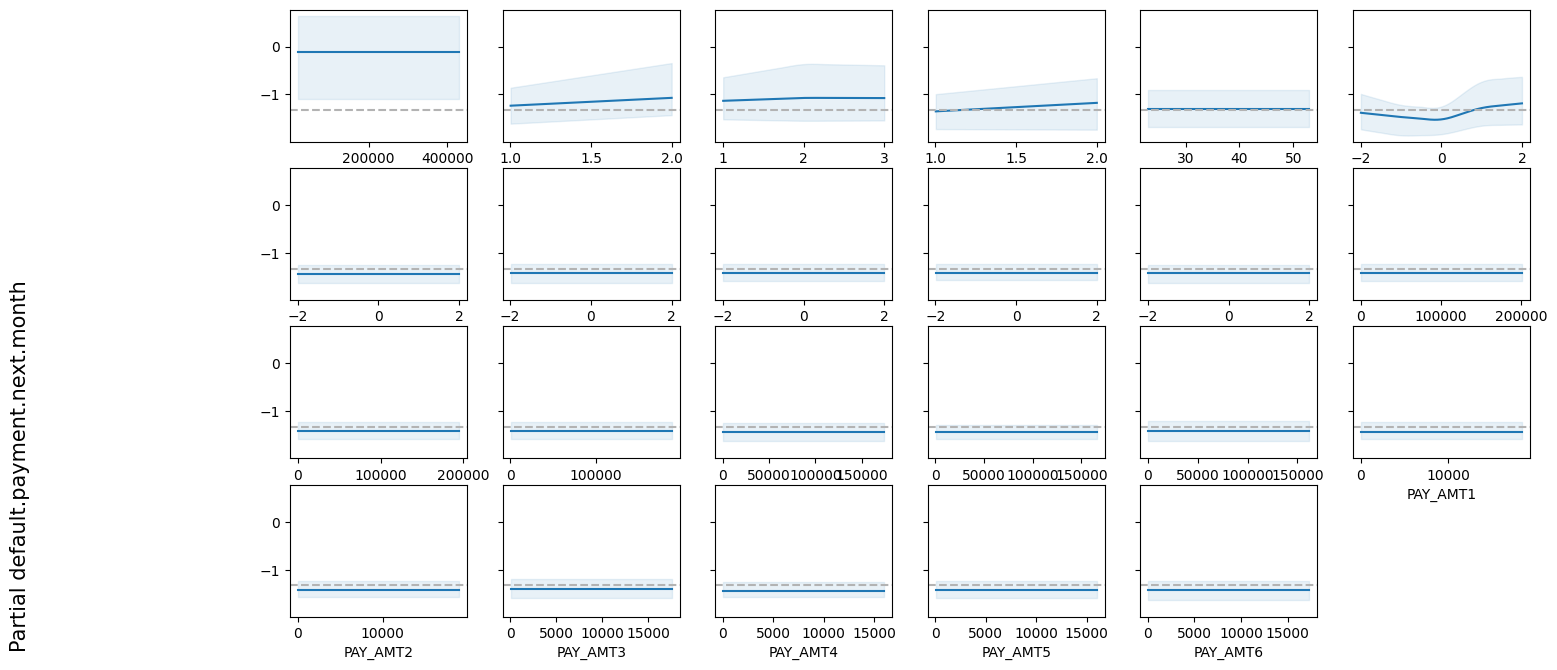

In [9]:
X_all = c[["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]]
pmb.plot_pdp(μ_, X_all, Y,
             grid=(6, 6),
             figsize=(16, 12),
)

The model isn't as good as only using financial predictors, but I'm seeing that the social variables are  more important here and financial variables have no trends (with limit bal, pay_0 as exceptions).

I'm going to ignore this because I don't like the model!

In [10]:
vi_Xall = pmb.compute_variable_importance(idata, μ_, X_all)

#all this because I couldn't get the plot to actually work. this code took 2 days to create. damn.
feature_names = X_all.columns
vi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': vi_Xall['r2_mean']
})

vi_df_sorted = vi_df.sort_values(by='importance', ascending=False)

print(vi_df_sorted)




      feature    importance
4         AGE  1.981263e-01
3    MARRIAGE  1.845969e-01
2   EDUCATION  1.832172e-01
5       PAY_0  1.683056e-01
1         SEX  4.452099e-02
0   LIMIT_BAL  2.463535e-25
14  BILL_AMT4  0.000000e+00
21   PAY_AMT5  0.000000e+00
20   PAY_AMT4  0.000000e+00
19   PAY_AMT3  0.000000e+00
18   PAY_AMT2  0.000000e+00
17   PAY_AMT1  0.000000e+00
16  BILL_AMT6  0.000000e+00
15  BILL_AMT5  0.000000e+00
11  BILL_AMT1  0.000000e+00
13  BILL_AMT3  0.000000e+00
12  BILL_AMT2  0.000000e+00
10      PAY_6  0.000000e+00
9       PAY_5  0.000000e+00
8       PAY_4  0.000000e+00
7       PAY_3  0.000000e+00
6       PAY_2  0.000000e+00
22   PAY_AMT6  0.000000e+00


## MODEL 5 - BAL, EDUCATION, PAY_0, MARRIAGE (BEST ONE)

Output()

Output()

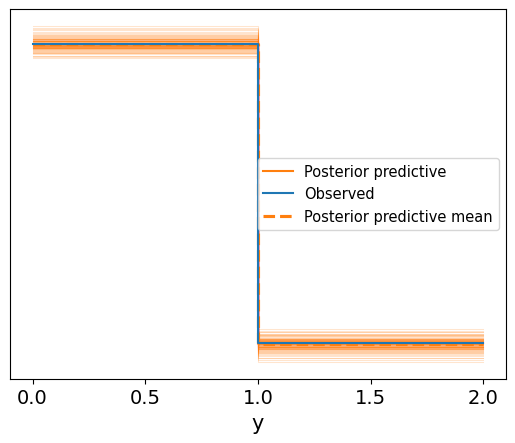

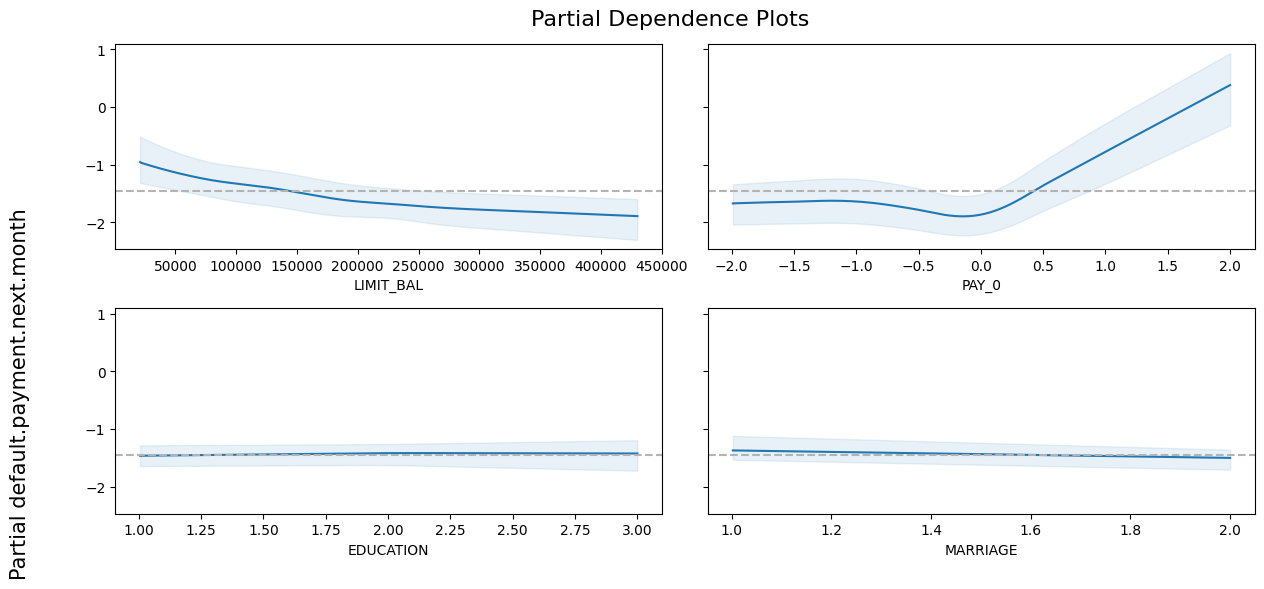

<Axes: ylabel='R²'>

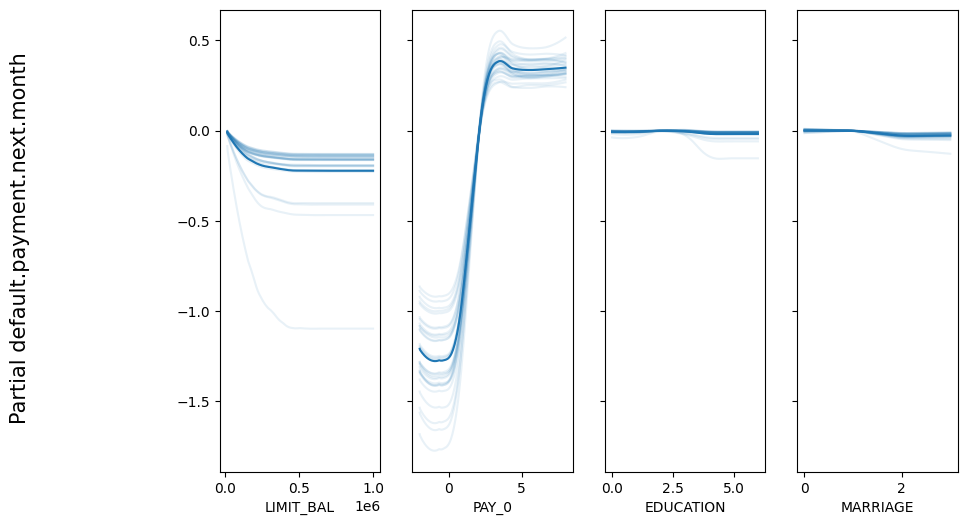

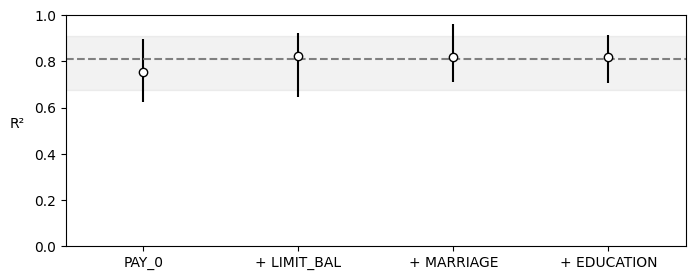

In [11]:
X = c[["LIMIT_BAL", "PAY_0", "EDUCATION", "MARRIAGE" ]]
Y = c["default.payment.next.month"]
X = pd.get_dummies(X, drop_first=True)

X = c[["LIMIT_BAL", "PAY_0", "EDUCATION", "MARRIAGE"]]

with pm.Model() as model:
    μ_ = pmb.BART('μ_', X, Y, m=20)
    p = pm.Deterministic('p', pm.math.sigmoid(μ_))
    y = pm.Bernoulli('y', p=p, observed=Y)

    idata = pm.sample(
        draws=200,
        tune=100,
        chains=1,
        cores=1,
        compute_convergence_checks=False,
        progressbar=True
    )


pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

#PDP plots
pmb.plot_pdp(μ_, X, Y, grid=(3, 2), figsize=(12, 8))
plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout()
plt.show()


#ICE plots
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

vi_penguins = pmb.compute_variable_importance(idata, μ_, X)

pmb.plot_variable_importance(vi_penguins)


This is the best model I've had! In model 2, I noticed that Education makes a bigger difference with either sex or marriage also mixed in. Turns out it was marriage! I put those two in, along with Limit and Pay_0 which I know are the most important predictors.

I know that other financial variables also have an effect, but I'm not going to use them because I know they have an effect (which is correlated with pay_0 and limit_bal anyways) so theres nothing to learn here. Unless someone's situation changes and they catch up on payment delays between pay_1  and pay_0, this won't make too much a different. I know it's possible for this to happen and it may slightly increase prediction power though.

##Interpretation

For my last model, I did the same as my "limit_bal, pay_0, marriage, sex, education, age" model but without age or sex. I think it's safe to say that gender and age are not predictors of credit card defaults in Taiwan. Interesting stuff. Also, my financials only model had some predictive power but not as much as also considering important social factors. While banks can't do the same thing we do and decide who to cover 7/11 trips for to based off personality insights, they can do their best by using social factors like marriage and education along with data.

Also, I think its interesting that this is the best model to get rid of outliers,  meaning there could be people who's context changes the role of financial data like:

someone who finally pays off months 1-6 to be more financially stable in recent months

or someone who, despite social factors that indicate higher likelihood of defaults, is in a good position to avoid defaulting

My PDP plots show the same interesting caveats I talked about in earlier models. I don't know if marriage or education on their own are good predictors, but I do know that together they tell you something about the likelihood of defaulting. A quick ChatGPT prompt on taiwanese culture returns the following:

"Definitely a cultural flavor to it. Taiwan has a Confucian heritage, where education is revered, and marriage can carry social expectations of maturity and stability. That makes the marriage-education combo more predictive there than in, say, the U.S., where individualism might reduce the weight of those factors."



---



From my prompt, "Would you believe me if I said variable interactions between marriage and education affect credit card default probabilities in taiwan, but not sex or age? is this something specific to taiwanese culture?"


ChatGPT
"This might sound surprising, but in the Taiwanese context, maybe not so much:

Sex: Taiwan has relatively high gender equality in financial independence compared to some neighboring countries. Both men and women have access to education, work, and credit, so sex alone might not be a strong predictor.

Age: Age often gets washed out when you control for income, education, and marital status. A 28-year-old with a good job and a solid credit history behaves more like a 40-year-old in the same boat than like a peer without those advantages."